In [552]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader

In [583]:
# 設定要使用的特徵
features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
# 讀取資料
df = pd.read_csv('0050.TW.csv', index_col=0)
df = df.round(3)
df.index = list(map(lambda x:datetime.datetime.strptime(x, '%Y-%m-%d'), df.index))
df.head()

# 设置显示选项
pd.set_option('display.max_colwidth', None)
torch.set_printoptions(profile='full')

print(df)
timeseries = df[features].values.round(3)

print(timeseries)

              Open    High     Low   Close  Adj Close    Volume
2023-03-21  118.50  118.75  118.20  118.65    114.277   3591870
2023-03-22  119.45  120.90  119.45  120.90    116.444  14242127
2023-03-23  120.65  122.30  120.45  121.85    117.359  15532979
2023-03-24  122.00  122.30  121.55  122.20    117.696  13457394
2023-03-27  121.75  121.90  121.20  121.45    116.974  10644595
...            ...     ...     ...     ...        ...       ...
2024-03-14  154.90  155.80  154.30  155.10    155.100   8318618
2024-03-15  154.30  154.75  153.00  153.00    153.000   8600954
2024-03-18  153.00  154.50  153.00  154.40    154.400  17937768
2024-03-19  153.40  154.55  153.00  154.05    154.050   8569789
2024-03-20  154.20  155.30  153.00  153.20    153.200  10080404

[243 rows x 6 columns]
[[     118.5        118.75       118.2        118.65       114.277
   3591870.   ]
 [     119.45       120.9        119.45       120.9        116.444
  14242127.   ]
 [     120.65       122.3        120.45   

In [584]:
LR = 0.0001
EPOCH = 500
FEATURES = [ "Close"]
LABEL =  "Close"
TRAIN_END=-30
DAYS_BEFORE=7

In [585]:
def getData(df, feature_columns, label_column, train_end=-30, days_before=30, standardize=True):
    series = df.copy()
    mean = series.mean()
    std = series.std()
    if standardize:
        series = (series - mean)/std

    # 划分数据
    # 0 ~ train_end 的为训练数据，但实际上，最后的 n 天只是作为 label
    # 而 train 中的 label，可用于 test
    train_series = series[feature_columns][:train_end]
    # 创建训练集
    train_feature = pd.DataFrame()
    train_label = pd.DataFrame()

    # 通过移位，创建历史 days_before 天的数据
    for i in range(days_before):
    # 当前数据的 7 天前的数据，应该取 开始到 7 天前的数据； 昨天的数据，应该为开始到昨天的数据，如：
    # [..., 1,2,3,4,5,6,7] 昨天的为 [..., 1,2,3,4,5,6]
    # 比如从 [2:-7+2]，其长度为 len - 7
        train_feature['bday%d' % i] = train_series[i: -days_before + i].values.tolist()

    # 获取对应的 label
    train_label['y'] = series[label_column].to_numpy()[days_before:]
    #print(train_data["bday4"])
    return train_feature, train_label, df.index.tolist()

In [641]:
# 定義模型
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()

        # 設定輸入尺寸為特徵數量
        self.lstm = nn.LSTM(
            input_size=len(FEATURES),
            hidden_size=64,
            num_layers=1,
            batch_first=True)

        self.out = nn.Sequential(
            nn.Linear(64, 1))

    def forward(self, x):
        r_out, (h_n, h_c) = self.lstm(x, None)  # None 表示 hidden state 會用全 0 的 state
        out = self.out(r_out[:, -1, :])  # 取最後一天作為輸出

        return out

In [653]:
class TrainSet(Dataset):
    def __init__(self, x, y):
        # data 取前多少天的数据， label 取最后一天的数据
        self.data, self.label = x[:, :].float(), y[:, -1].float()
        print("SELFLLLL")
        print(self.data)
    def __getitem__(self, index):
        return self.data[index], self.label[index]

    def __len__(self):
        return len(self.data)

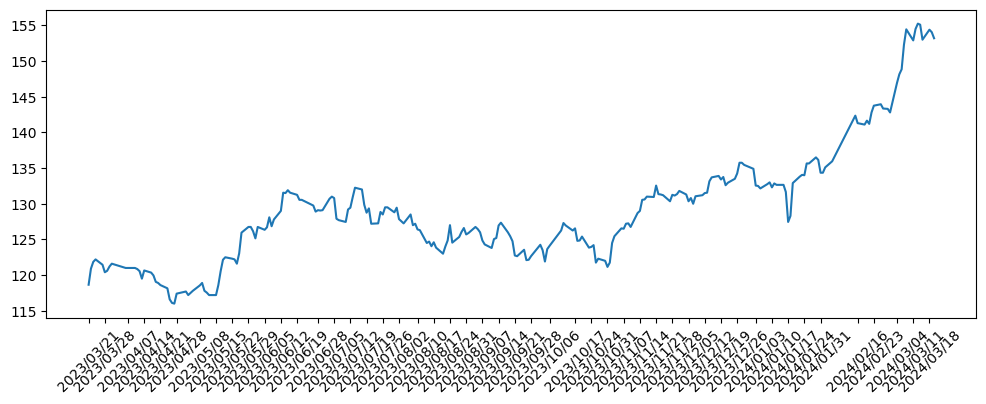

SELFLLLL
tensor([[[-1.2710],
         [-0.9925],
         [-0.8749],
         [-0.8315],
         [-0.9244],
         [-1.0544],
         [-1.0296]],

        [[-0.9925],
         [-0.8749],
         [-0.8315],
         [-0.9244],
         [-1.0544],
         [-1.0296],
         [-0.9553]],

        [[-0.8749],
         [-0.8315],
         [-0.9244],
         [-1.0544],
         [-1.0296],
         [-0.9553],
         [-0.9058]],

        [[-0.8315],
         [-0.9244],
         [-1.0544],
         [-1.0296],
         [-0.9553],
         [-0.9058],
         [-0.9801]],

        [[-0.9244],
         [-1.0544],
         [-1.0296],
         [-0.9553],
         [-0.9058],
         [-0.9801],
         [-0.9801]],

        [[-1.0544],
         [-1.0296],
         [-0.9553],
         [-0.9058],
         [-0.9801],
         [-0.9801],
         [-0.9801]],

        [[-1.0296],
         [-0.9553],
         [-0.9058],
         [-0.9801],
         [-0.9801],
         [-0.9801],
         [-0.9987]]

In [654]:
# 数据集建立
train_feature, train_label, df_index= getData(df, FEATURES, LABEL, days_before=DAYS_BEFORE, train_end=TRAIN_END)
# 获取所有原始数据
all_series = np.array(df[LABEL].tolist())
# 绘制原始数据的图
plt.figure(figsize=(12,4))
plt.plot(df_index, all_series, label='real-data')
# 设置 X 轴的刻度
plt.xticks(df_index[::5], pd.to_datetime(df_index[::5]).strftime('%Y/%m/%d'),rotation=45)
# 隐藏 X 轴的次刻度
plt.minorticks_off()
plt.show()

# flatern each day in train data
train_feature_tensor = torch.Tensor(np.array(train_feature.values.tolist()))
train_label_tensor = torch.Tensor(np.array(train_label.values.tolist()))
# 创建 dataloader

train_set = TrainSet(train_feature_tensor, train_label_tensor)
# print(train_set.data)

train_loader = DataLoader(train_set, batch_size=10, shuffle=True)
print(train_loader.dataset)

In [658]:
#訓練
# rnn = torch.load('rnn.pkl')
rnn = LSTM()

optimizer = torch.optim.SGD(rnn.parameters(), lr=LR) # optimize all cnn parameters
loss_func = nn.MSELoss()
for step in range(EPOCH):
    for tx, ty in train_loader:
        print(tx.shape)
        print(ty)
        optimizer.zero_grad() # clear gradients for this training step
        tx=torch.squeeze(tx)
        tx=torch.unsqueeze(tx,-1)
#         print(tx.shape)
#         print(tx)
#         output,(h_n,c_n) = rnn(tx)
        output = rnn(tx[1,:])
        ty=torch.squeeze(ty)
        ty=torch.unsqueeze(ty,-1)
        # print(ty.shape)
        loss = loss_func(output[:,-1,:], ty)
        # print(loss)

        # loss.backward() # back propagation, compute gradients
        # optimizer.step()
    print(step, loss.cpu())
    if step % 10:
        torch.save(rnn, 'rnn.pkl')
torch.save(rnn, 'rnn.pkl')

torch.Size([10, 7, 1])
tensor([-0.8315, -0.2373, -0.7944, -0.6273,  0.0659, -0.4602, -0.0083, -0.4354,
        -0.5716, -1.4505])


IndexError: too many indices for tensor of dimension 2

In [639]:
# 生成預測資料
generate_data_train = []
generate_data_test = []

# 測試資料開始的索引
test_start = len(all_series) + TRAIN_END

# 對所有的資料進行相同的歸一化
all_series = (all_series - train_mean) / train_std
all_series = torch.Tensor(all_series)

for i in range(DAYS_BEFORE, len(all_series)):
    x = all_series[i - DAYS_BEFORE:i]
    # 將 x 填充到 (bs, ts, is) 中的 timesteps
    x = torch.unsqueeze(torch.unsqueeze(x, dim=0), dim=2)

    if torch.cuda.is_available():
        x = x.cuda()

    y = rnn(x)

    if i < test_start:
        generate_data_train.append(torch.squeeze(y.cpu()).detach().numpy()

SyntaxError: unexpected EOF while parsing (133055656.py, line 23)